In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline #preprocessing 
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from imblearn.pipeline import Pipeline as pipe #model processed data


In [169]:
pkl_path = 'cone_burnout_data2.pkl'

In [171]:
df = pd.read_pickle(pkl_path)

In [172]:
df.head()

,employee_obj_id,clicks_count,patients_accessed_count,after_hours_count,value,hire_date,term_date,indicator
0,16,10544.0,832.0,622.0,MHC-CORE LAB,2015-12-27,None,0
1,60056,37.0,9.0,4.0,ARMC-SUPPLY CHAIN,2008-07-28,None,0
2,61660,5407.0,1806.0,666.0,SW-ITS-CLINICAL INFO SYS,2004-07-12,None,0
3,119083,191682.0,2552.0,1454.0,PSC-PIEDMONT SENIOR CARE,2017-01-09,None,0
4,119085,5504.0,352.0,151.0,PRIMARY CARE AT POMONA,2010-12-05,2019-04-10,1


In [173]:
df = df.drop(['value','hire_date','term_date'],axis=1)

In [174]:
y_check = df['indicator']
y_check=y_check.astype('int')
print(y_check.value_counts())

0    15490
1     4108
Name: indicator, dtype: int64


In [175]:
train_df = df.sample(frac=0.7, random_state=1019)
test_df = df.drop(train_df.index)

In [176]:
true_y = train_df['indicator']
test_y = test_df['indicator']

In [177]:
true_y=true_y.astype('int')
test_y=test_y.astype('int')

In [178]:
train_X = train_df.drop(['employee_obj_id','indicator'],axis=1)
test_X = test_df.drop(['employee_obj_id','indicator'],axis=1)

In [179]:
train_X = train_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT', 
                          'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 
test_X = test_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT',
                        'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 

In [180]:
train_X.head()

,CLICKS,NUM_PATIENTS,AFTER_HOURS
5391,5766.0,577.0,369.0
15639,NaN,NaN,NaN
18185,NaN,NaN,NaN
15337,NaN,NaN,NaN
10761,NaN,NaN,NaN


In [181]:
true_y.value_counts()

0    10878
1     2841
Name: indicator, dtype: int64

In [182]:
def transform_pipeline(categorical_features,numeric_features):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    #categorical_transformer = Pipeline(steps=[
    #    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    #    ('onehot', OneHotEncoder(handle_unknown='ignore'))])    
    
    ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),])
        #('cat', categorical_transformer, categorical_features)])  
    
    return ct  

In [183]:
numerical_features = ['NUM_PATIENTS','CLICKS','AFTER_HOURS']
categorical_features = ['DEPT']

In [184]:
ct = transform_pipeline(categorical_features,numerical_features)

In [185]:
#apply the transform 
X_train_trans = ct.fit_transform(train_X)
X_test_trans = ct.transform(test_X)

In [186]:
X_train_trans

array([[-0.67800153, -1.35082198, -0.69456393],
       [-0.2006612 , -0.138728  , -0.19727179],
       [-0.2006612 , -0.138728  , -0.19727179],
       ...,
       [-0.65796537,  0.11748802, -0.64334284],
       [ 0.62237344, -0.94977835, -0.16196405],
       [-0.2006612 , -0.138728  , -0.19727179]])

In [187]:
def ml_pipeline():
    #smt_step = ("smt", SMOTE(sampling_strategy=.15,random_state=1019))
    
    ss_step = ('ss', StandardScaler(with_mean=False))

    rfc_step = ('rfc',RandomForestClassifier())
    #smt_step,
    pipeline_steps = [ ss_step, rfc_step]
    
    ml_pipe = pipe(pipeline_steps)
    
    return ml_pipe

In [188]:
ml_pipe = ml_pipeline()

In [189]:
#fit to train
ml_pipe.fit(X_train_trans,true_y)

Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('rfc', RandomForestClassifier())])

In [190]:
#predict on test
y_pred = ml_pipe.predict(X_test_trans)
y_prob = ml_pipe.predict_proba(X_test_trans)[:,1]

In [191]:
#metrics

In [192]:
scores = cross_val_score(ml_pipe, X_train_trans, true_y, cv=5, scoring="roc_auc")

In [193]:
scores

array([0.63262479, 0.62442879, 0.63695338, 0.63118882, 0.63190262])

In [194]:
cr = classification_report(test_y,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.99      0.88      4612
           1       0.71      0.08      0.14      1267

    accuracy                           0.79      5879
   macro avg       0.75      0.53      0.51      5879
weighted avg       0.78      0.79      0.72      5879



In [195]:
cm = confusion_matrix(test_y,y_pred)
print(cm)

[[4571   41]
 [1168   99]]


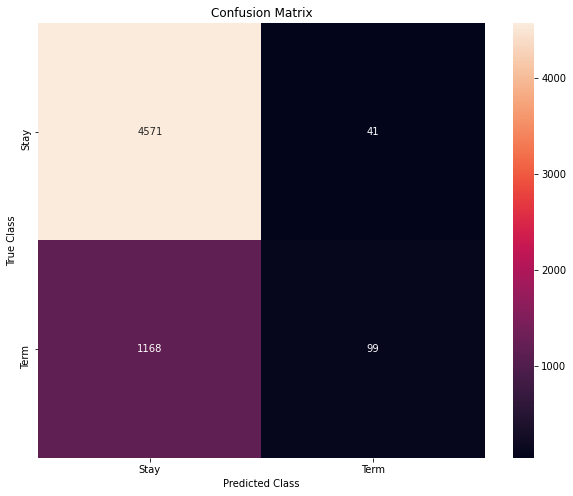

In [196]:
def plot_cm(cm):
    labels = ['Stay','Term']
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show

plot_cm(cm)

In [197]:
fpr, tpr, thresholds = roc_curve(test_y,y_prob)
roc_auc = auc(fpr,tpr)

In [198]:
def plot_roc(fpr, tpr, thresholds,roc_auc):
    plt.figure(figsize=(15,8))
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

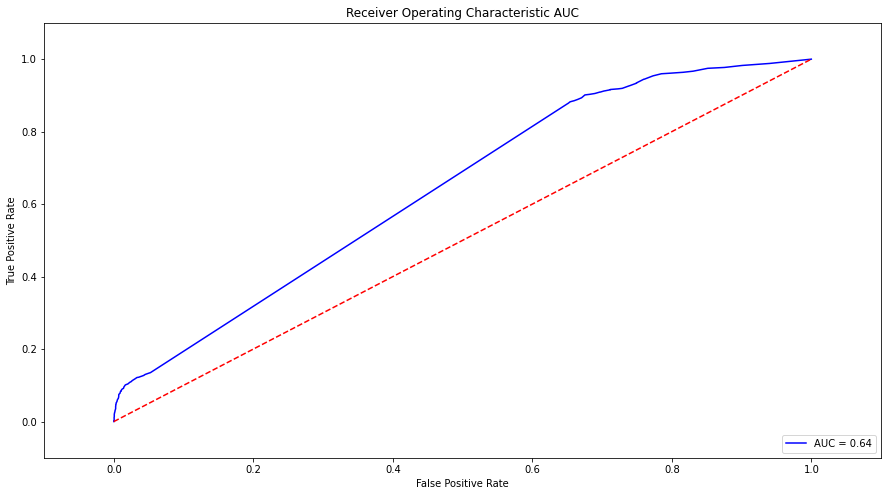

In [199]:
plot_roc(fpr, tpr, thresholds,roc_auc)

In [201]:
#ooh a different way to make a pipeline...
num_transformer = Pipeline(steps=[
                  ('imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['NUM_PATIENTS','CLICKS','AFTER_HOURS']
categorical_features = ['DEPT']

ct = ColumnTransformer(transformers=[
            ('numerical_preprocessing', num_transformer, numerical_features),],remainder='passthrough',verbose=True)
#('categorical_preprocessing', cat_transformer, categorical_features)],
    
# Create the classifier
classifier = RandomForestClassifier()

# Create the overall model as a single pipeline
pipeline = Pipeline([("transform_inputs", ct), ("classifier", classifier)])

pipeline.fit(train_X, true_y)

#onehot_columns = pipeline.named_steps['transform_inputs'].named_transformers_['categorical_preprocessing'].named_steps['onehot'].get_feature_names(input_features=categorical_features)


#you can get the values transformed with your pipeline
X_values = ct.fit_transform(train_X)

[ColumnTransformer]  (1 of 1) Processing numerical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing numerical_preprocessing, total=   0.0s


In [202]:
cols = numerical_features #+ list(onehot_columns)

In [203]:
df_from_array_pipeline = pd.DataFrame(X_values, columns = cols) #.toarray()

In [204]:
feature_importance = pd.Series(data= pipeline.named_steps['classifier'].feature_importances_, index = np.array(cols))

In [205]:
feature_importance

NUM_PATIENTS    0.331969
CLICKS          0.352091
AFTER_HOURS     0.315939
dtype: float64